In [ ]:
!pip install pymanopt

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/PSC/PSC"
output_folder = "/content/drive/MyDrive/PSC/experiments"

import sys
sys.path.insert(0, DRIVE_PATH)

import scipy.io as sio

import numpy as np
from pymanopt.manifolds.stiefel import Stiefel
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

from utils import rotation_mat, get_samples, dist_Gr, dist_St, projection_cost, nuc_cost
from projections import manopt_alpha, PCA, yhat_alpha_all

# Load brain data

Muldoon SF, Pasqualetti F, Gu S, Cieslak M, Grafton ST, Vettel JM, et al. (2016) Stimulation-Based Control of Dynamic Brain Networks. PLoS Comput Biol 12(9): e1005076. https://doi.org/10.1371/journal.pcbi.1005076

In [ ]:
folder_name = 'connectivity_matrices'
fnames = []
netmat = {}
subjects = []

for i in range(1, 9):
    for j in range(1, 4):
        fnames.append(f'subject{i}_scan{j}.mat')
        subjects.append(i)

for fn in fnames:
    mat_contents = sio.loadmat(os.path.join(output_folder, folder_name, fn))
    netmat[fn] = mat_contents['connectivity_density_matrix']

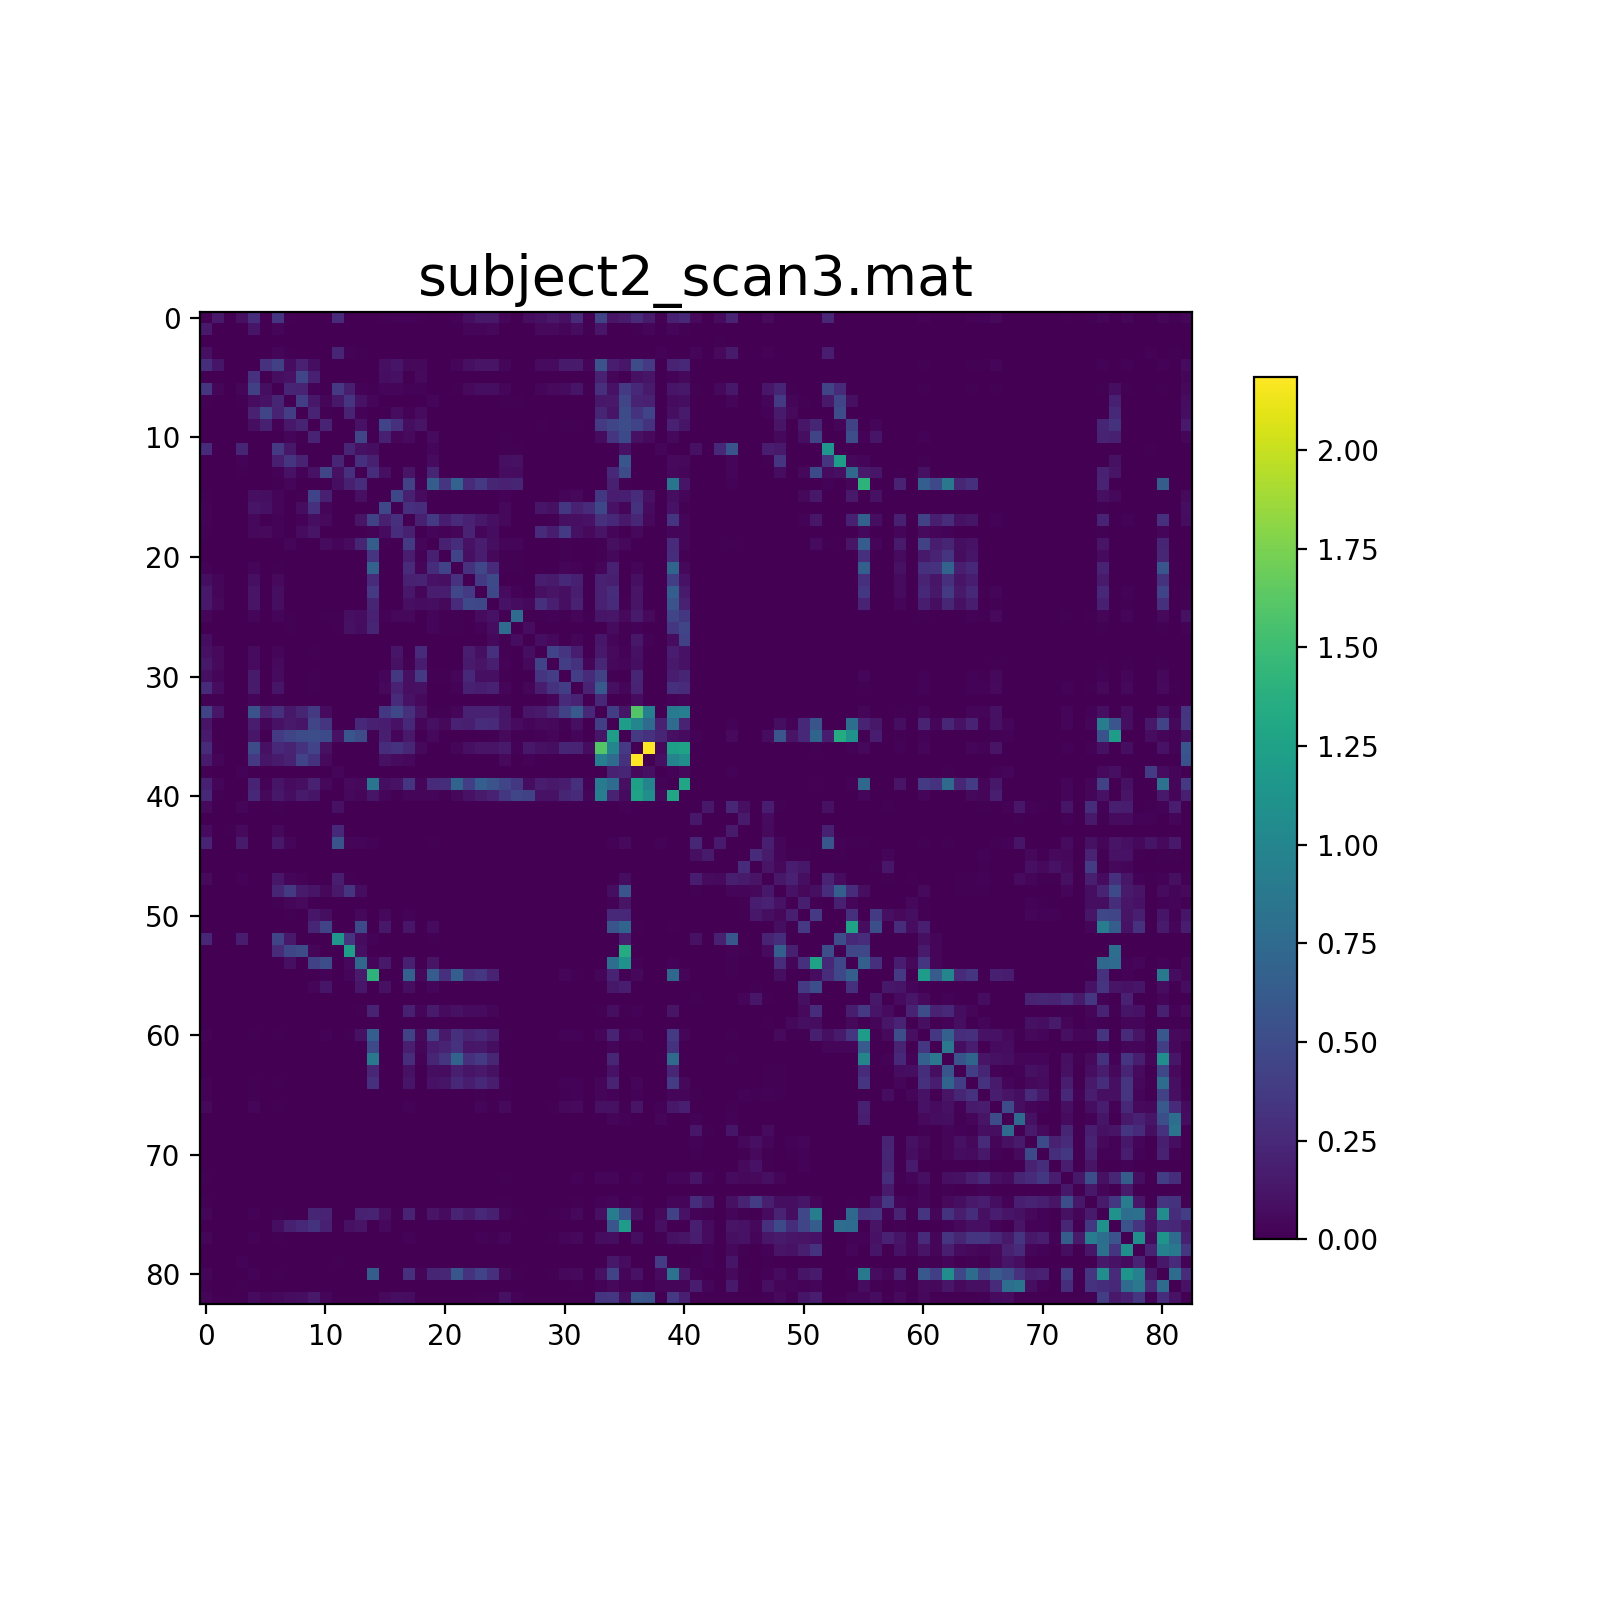

subject2_scan3.mat (83, 83)


In [ ]:
#visualize one brain scan
idx = 5

plt.figure(figsize=(8, 8))
plt.title(fnames[idx], fontsize=20)
plt.imshow(netmat[fnames[idx]])
plt.colorbar(shrink=0.7)
plt.show()

print(fnames[idx], netmat[fnames[idx]].shape)

# Get data on Stiefel manifold from brain data

(83,) (83, 83)


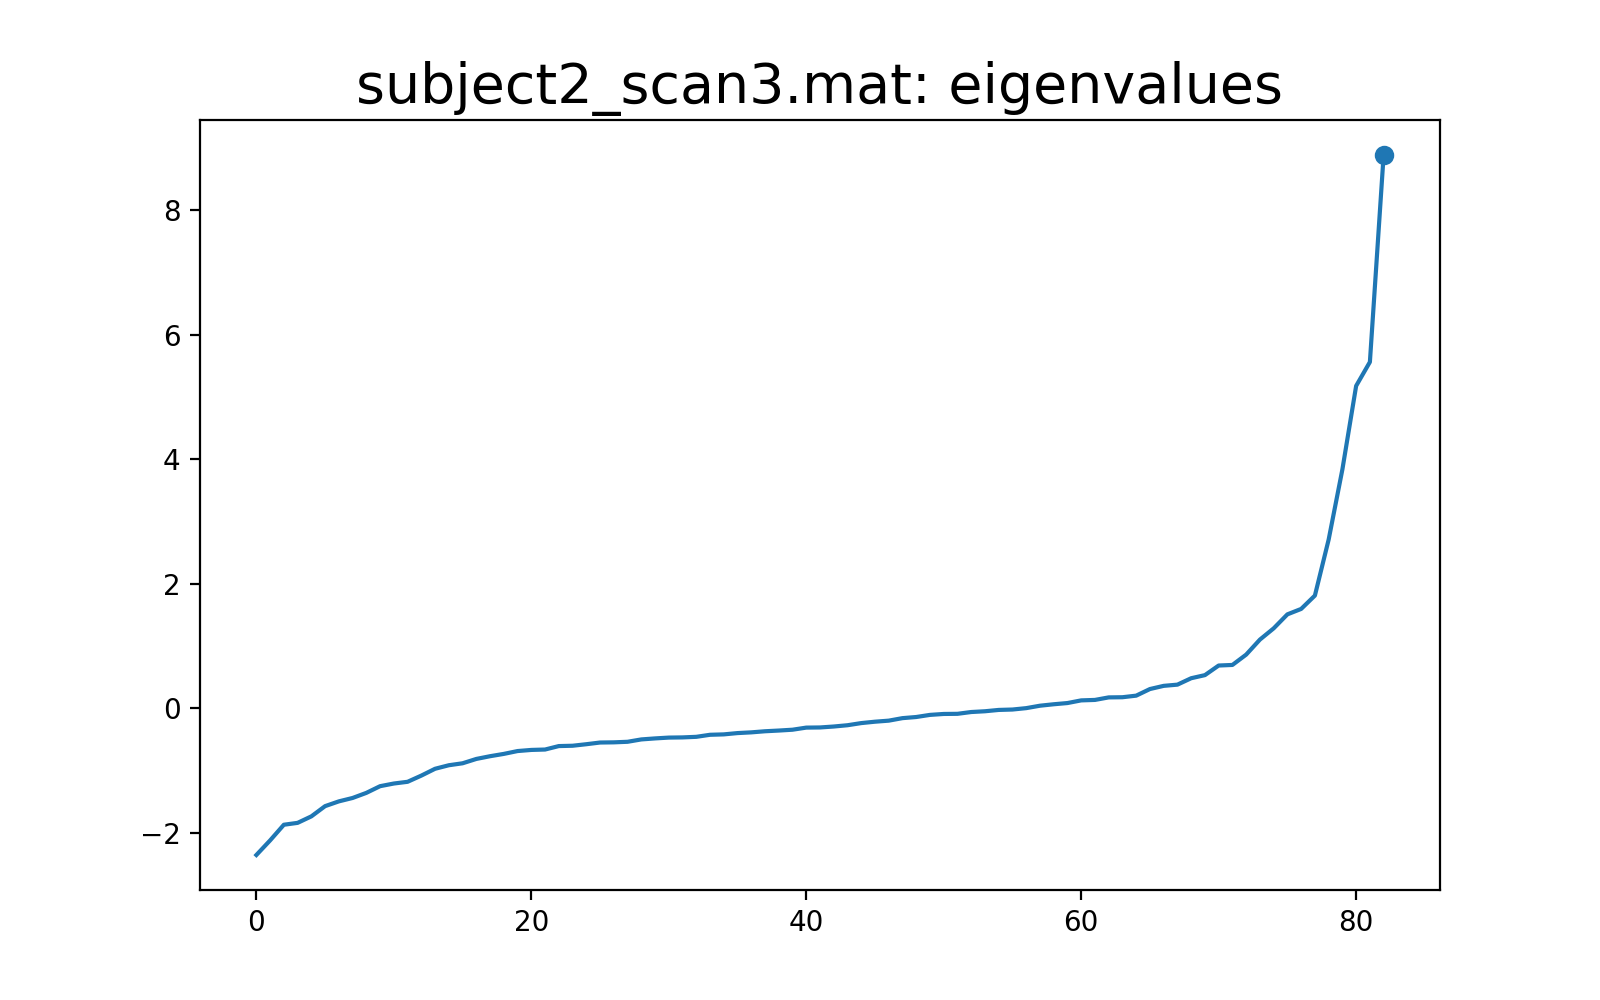

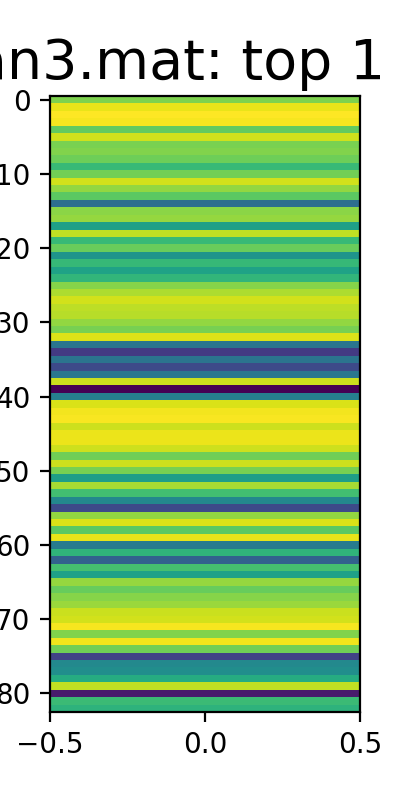

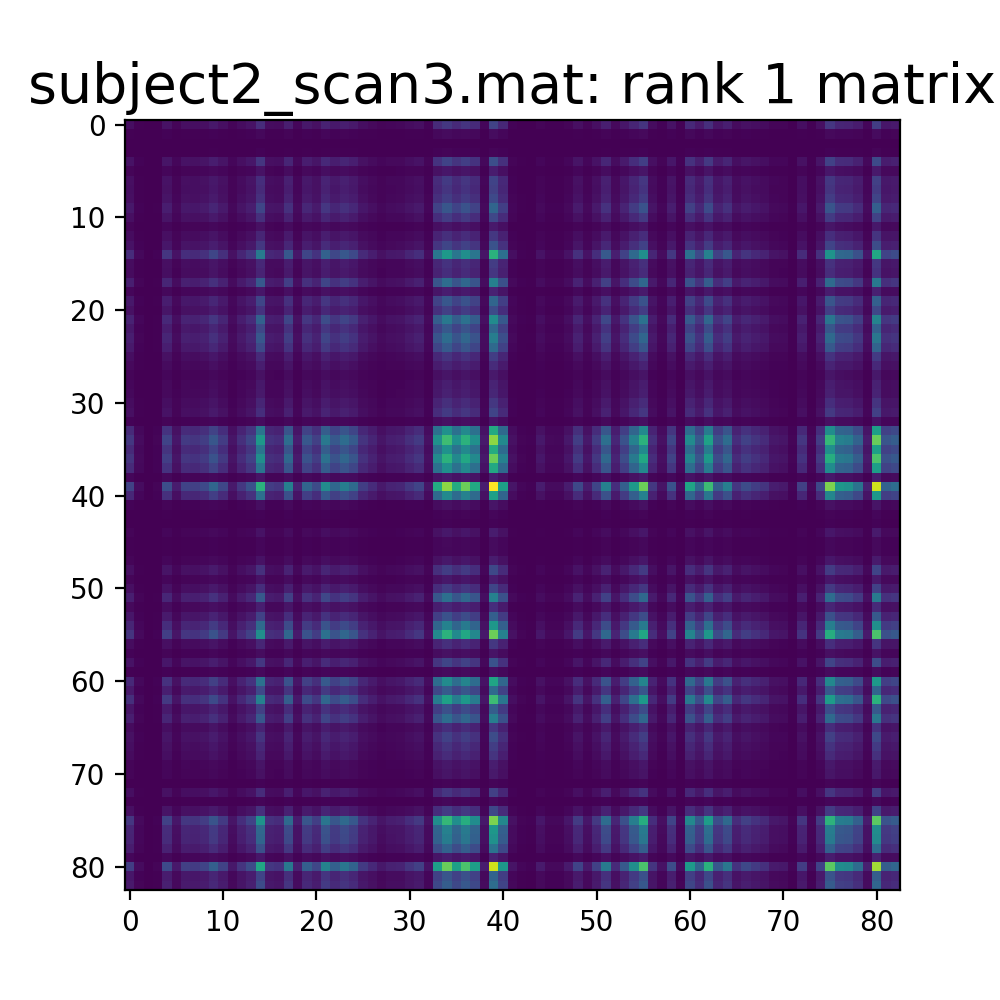

In [ ]:
N = netmat[fnames[0]].shape[0]
k = 1
n = 3
m = len(netmat)

ys = []

for fn, mat in netmat.items():
    w, v = np.linalg.eigh(mat)

    ys.append(v[:, -k:]) # eigenvectors of the connectivity matrix

    if fn == fnames[idx]:
        print(w.shape, v.shape)

        plt.figure(figsize=(8, 5))
        plt.plot(w)
        plt.scatter(len(w)-k, w[-k], marker='o')
        plt.title(f'{fn}: eigenvalues', fontsize=20)
        plt.show()

        plt.figure(figsize=(2, 4))
        plt.imshow(v[:, -k:], aspect='auto')
        plt.title(f'{fn}: top {k} eigenvectors', fontsize=20)
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.imshow(v[:, -k:].dot(v[:, -k:].T), aspect='auto')
        plt.title(f'{fn}: rank {k} matrix', fontsize=20)
        plt.show()

# Generate dimensionally reduced data

In [ ]:
ys = np.array(ys)
ys = ys - np.mean(ys, axis=0)

alpha_PCA = PCA(ys, n)
alpha_GD = manopt_alpha(ys, alpha_PCA)

X = yhat_alpha_all(alpha_GD, ys)
X = np.array(X).squeeze()

X = X*np.sign(X[:, -1]).reshape(-1, 1) # project to top hemisphere

Optimizing...
Terminated - min grad norm reached after 560 iterations, 4.76 seconds.



In [ ]:
#Compare with Stiefel projection using alpha_PCA
X_PCA = yhat_alpha_all(alpha_PCA, ys)
X_PCA = np.array(X_PCA).squeeze()
X_PCA = X_PCA*np.sign(X_PCA[:, -1]).reshape(-1, 1) # project to top hemisphere

In [ ]:
ys_2d = np.squeeze(ys) #reformat data for comparison to other methods
#print(ys_2d.shape)

In [ ]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=3)
X_isomap = embedding.fit_transform(ys_2d)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_skpca = pca.fit_transform(ys_2d)

In [ ]:
from sklearn.manifold import TSNE

embedding = TSNE(n_components=3, perplexity=5)
X_tsne = embedding.fit_transform(ys_2d)

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(n_components=3)
X_ltsa = embedding.fit_transform(ys_2d)

# Visualize dimensionally reduced data

In [ ]:
def project_brain_to_sphere(X, fname, colors= subjects):
  X1 = X.copy()
  X1[:, 2] = X[:, 0]
  X1[:, 0] = X[:, 2]
  X = X1.copy()

  rotation=np.array([[0,0,1],[0,1,0],[1,0,0]]) #Apply overall rotation for easier visualization
  X=np.dot(X,rotation)

  #X = X.swapaxes(0, 1)

  fig = plt.figure(figsize=(16, 8))

  ax = plt.subplot(1, 2, 1, projection='3d')

  u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:20j]
  xx = np.cos(u) * np.sin(v)
  yy = np.sin(u) * np.sin(v)
  zz = np.cos(v)

  ax.plot_surface(xx, yy, zz, alpha=0.1)
  ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, s=100)

  X = X*np.sign(X[:, -1]).reshape(-1, 1) # project to top hemisphere
  #X = X*np.sign(X[:, 0]).reshape(-1, 1) # project to right hemisphere

  cut_angle = np.pi/12
  t = np.linspace(0,np.pi*2,100)
  r = np.sin(cut_angle)
  h = np.cos(cut_angle)
  ax.plot(r*np.cos(t), r*np.sin(t),h)

  ax.set_xlabel('Dim 3', fontsize=18, labelpad=10)
  ax.set_ylabel('Dim 2', fontsize=18, labelpad=10)
  ax.set_zlabel('Dim 1', fontsize=18, labelpad=10)
  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax.set_zticks([-1, -0.5, 0, 0.5, 1])
  ax.tick_params(axis='both', which='major', labelsize=18, pad=5)
  ax.tick_params(axis='both', which='minor', labelsize=18)
  ax.set_box_aspect((1, 1, 1) )
  # plt.title(title, fontsize=20)
  # plt.savefig(title+'.pdf', dpi=300)
  #plt.show()

  ax = plt.subplot(1, 2, 2, projection='3d')
  u, v = np.mgrid[0:2*np.pi:30j, 0:cut_angle:20j]
  xx = np.cos(u) * np.sin(v)
  yy = np.sin(u) * np.sin(v)
  zz = np.cos(v)
  ax.plot_surface(xx, yy, zz, alpha=0.1)
  ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, s=100)
  ax.plot(r*np.cos(t), r*np.sin(t), h)

  ax.set_xlabel('Dim 3', fontsize=18, labelpad=25)
  ax.set_ylabel('Dim 2', fontsize=18, labelpad=25)
  ax.set_zticks([])
  ax.tick_params(axis='both', which='major', labelsize=18, pad=15)
  ax.tick_params(axis='both', which='minor', labelsize=18)
  #ax.set_zlabel('Dimension 3', fontsize=16)
  ax.view_init(elev=90, azim=-90)
  #plt.title(title, fontsize=20)
  plt.tight_layout()
  plt.savefig(fname, dpi=300)
  #plt.show()

def plot_manifold_learning_methods(X, title):
  fig = plt.figure(figsize=(16,8))
  ax = fig.add_subplot(121, projection='3d')
  ax.scatter(X[:,0], X[:,1], X[:,2], c=subjects, s=100)
  ax.set_xlabel('Dim 1', fontsize=18, labelpad=10)
  ax.set_ylabel('Dim 2', fontsize=18, labelpad=10)
  ax.set_zlabel('Dim 3', fontsize=18, labelpad=10)
  ax.set_title(title, fontsize=20)

  X = X*np.sign(X[:, 0]).reshape(-1, 1) # project to positive x axis

  ax = fig.add_subplot(122, projection='3d')
  ax.scatter(X[:,0], X[:,1], X[:,2], c=subjects, s=100)
  ax.set_xlabel('Dim 1', fontsize=18, labelpad=25)
  ax.set_ylabel('Dim 2', fontsize=18, labelpad=25)
  ax.set_zlabel('Dim 3', fontsize=18, labelpad=25)
  # ax.view_init(elev=0, azim=0)
  ax.set_title(title+', projected across dim 1 = 0', fontsize=20)

  plt.tight_layout()
  plt.show()

## PSC

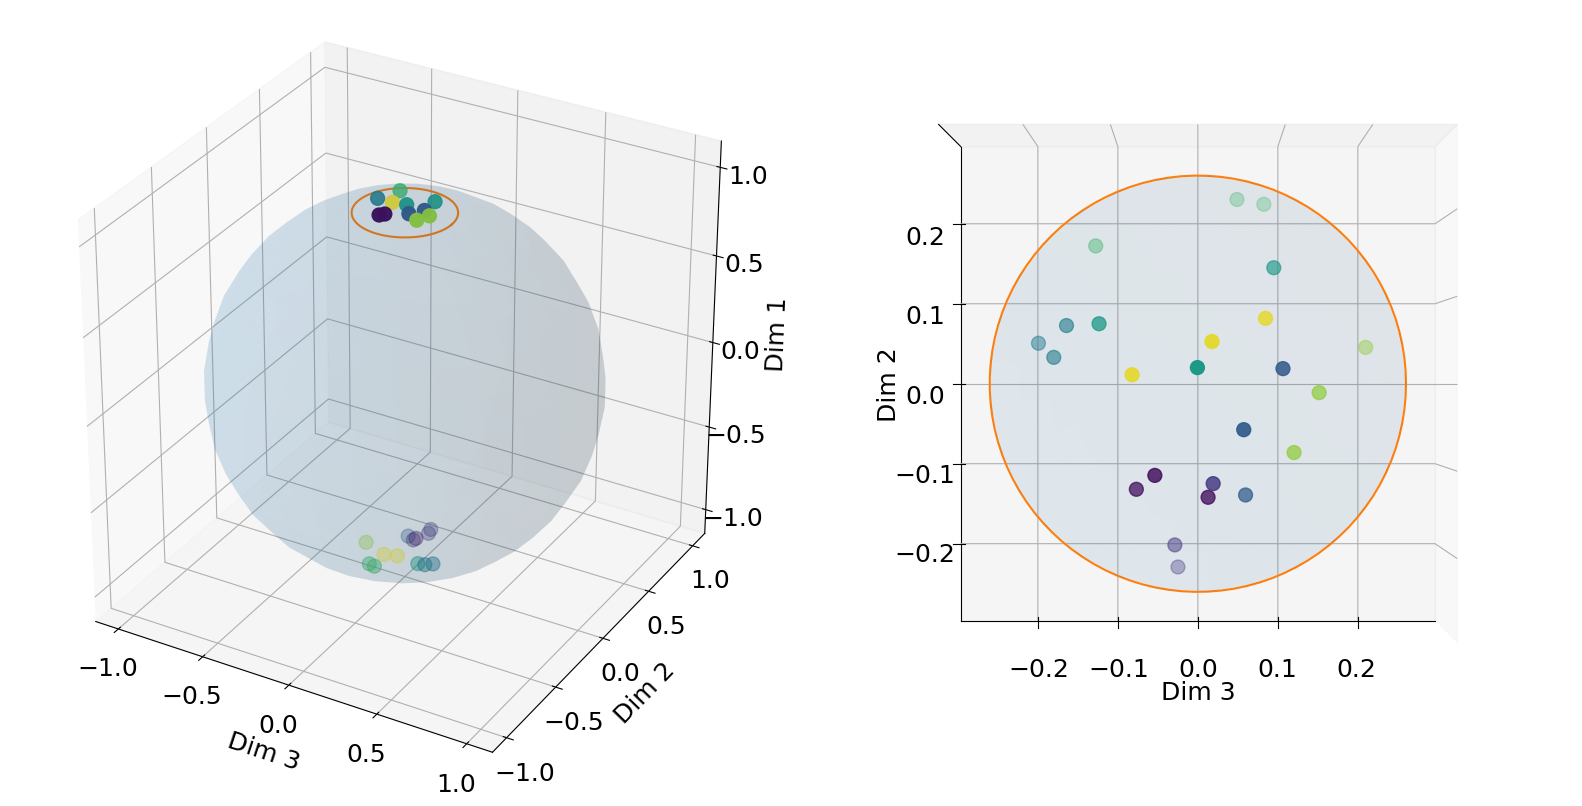

In [ ]:
project_brain_to_sphere(X, os.path.join(output_folder, 'brain_projected.pdf'), colors=subjects)

## PSC without gradient descent

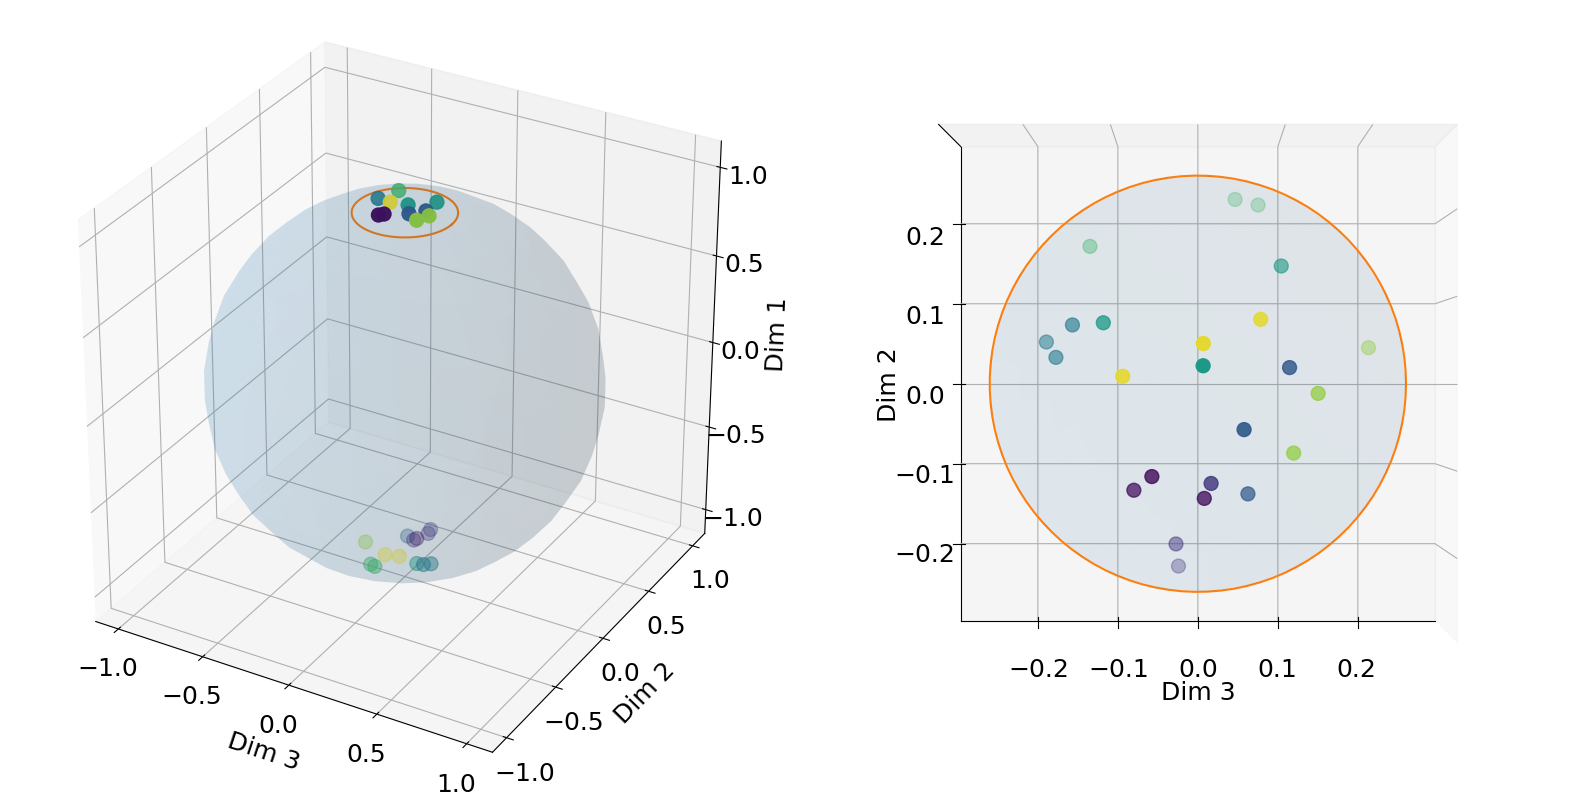

In [ ]:
project_brain_to_sphere(X_PCA, os.path.join(output_folder, 'brain_projected_pca.pdf'), colors = subjects)
# plt.show()

## ISOMAP

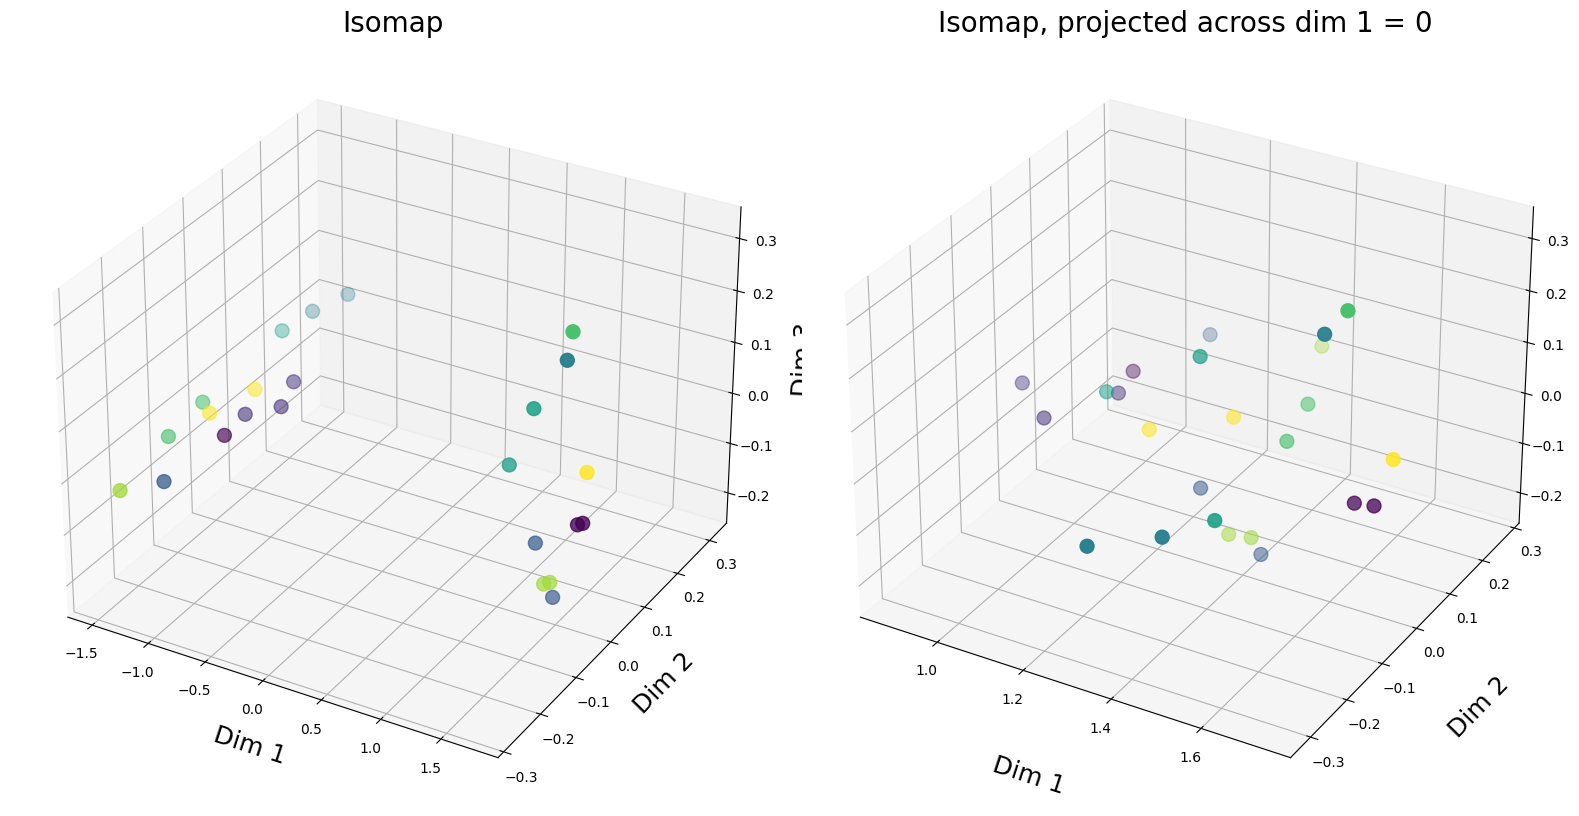

In [ ]:
plot_manifold_learning_methods(X_isomap, 'Isomap')

## Standard PCA

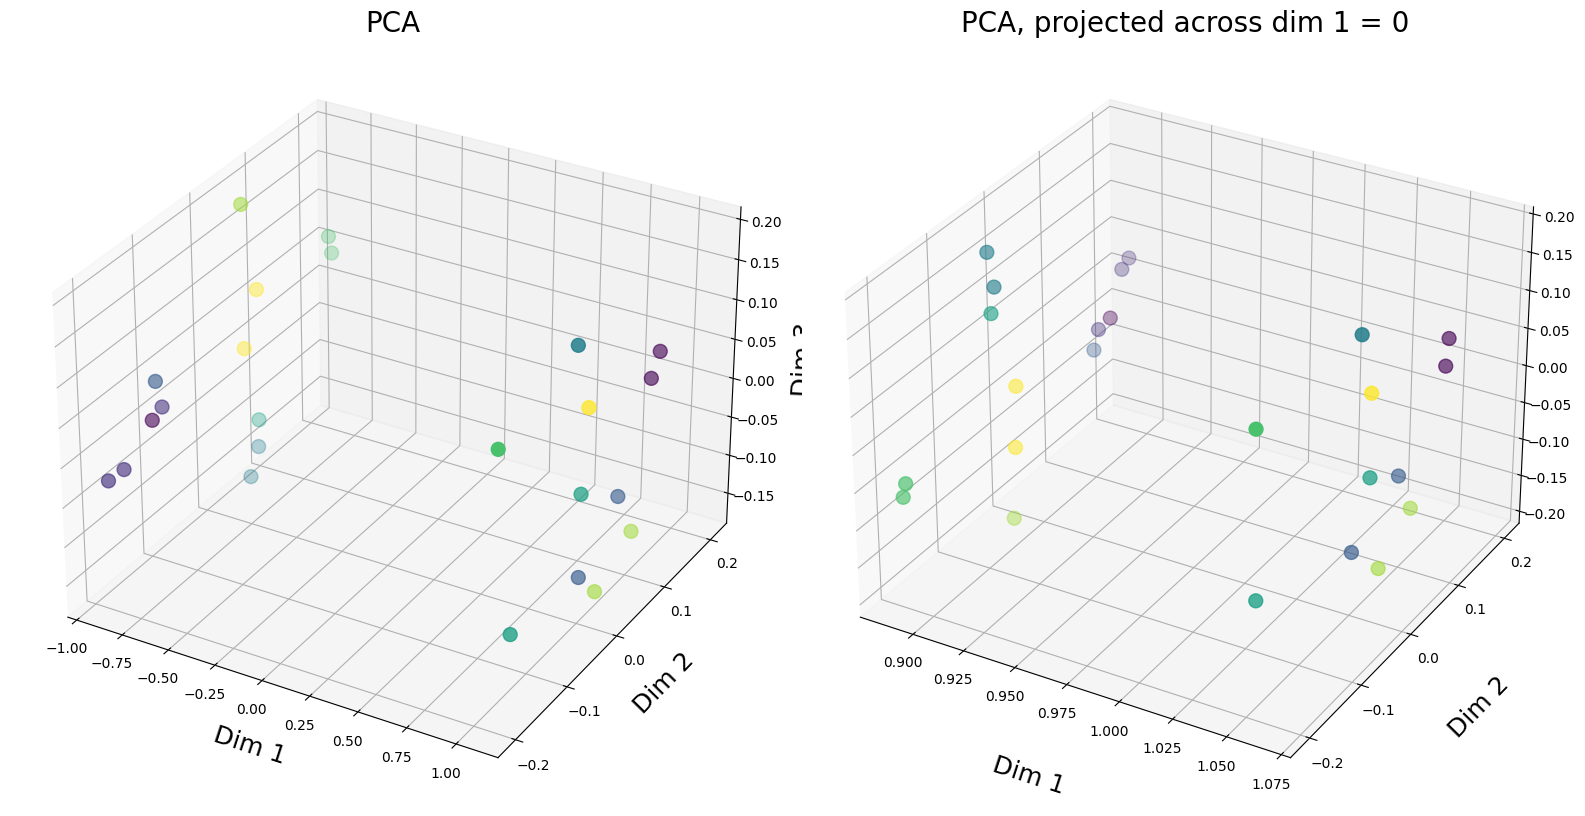

In [ ]:
plot_manifold_learning_methods(X_skpca, 'PCA')

## t-SNE

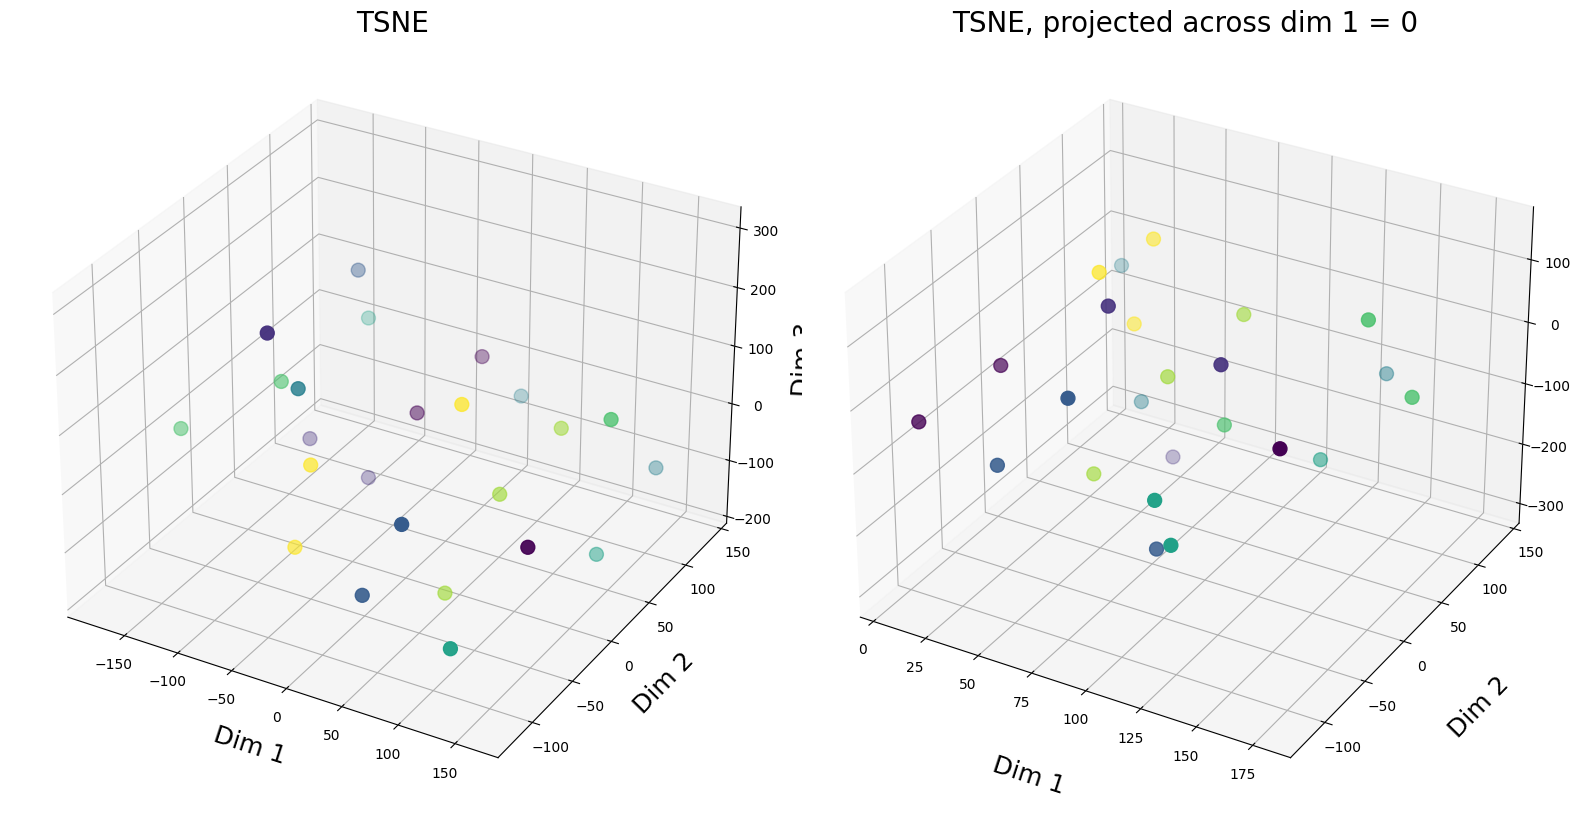

In [ ]:
plot_manifold_learning_methods(X_tsne, 'TSNE')

## LTSA

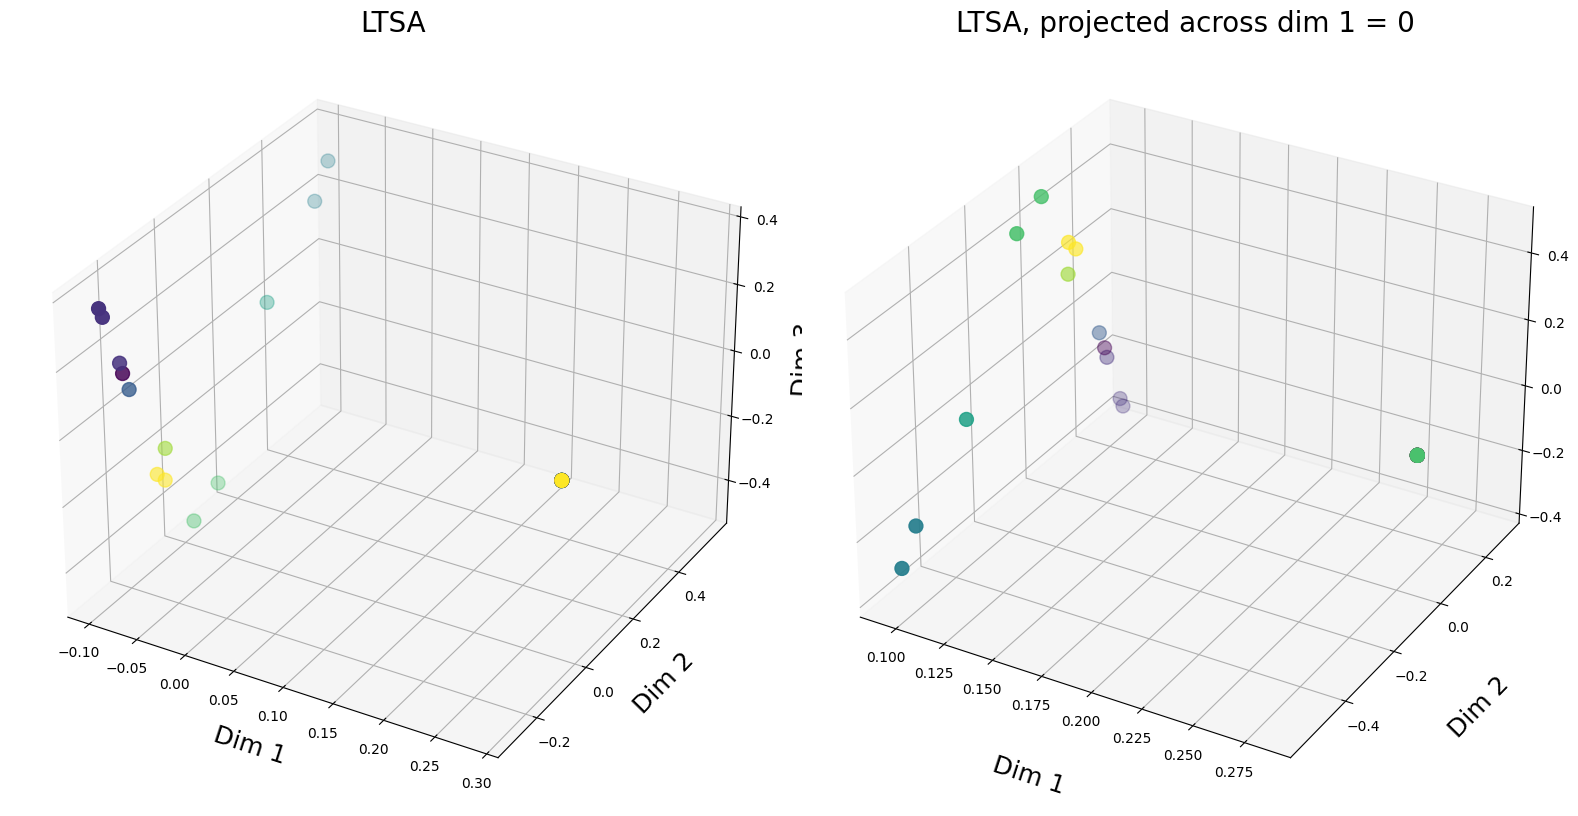

In [ ]:
plot_manifold_learning_methods(X_ltsa, 'LTSA')

# Clustering Score Comparisons

## Clustering score reporting

In [ ]:
import sklearn.metrics as metrics
from sklearn.cluster import KMeans

def score_list(true_labels, pred_labels, method):
  scores_df=pd.DataFrame(columns=['Adjusted Rand','Adjusted Mutual Info','Homogeneity','Completeness','Fowlkes-Mallows','Method'])

  scores_df.loc[0]=[metrics.adjusted_rand_score(true_labels, pred_labels),metrics.adjusted_mutual_info_score(true_labels, pred_labels),metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)[0],metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)[1],metrics.fowlkes_mallows_score(true_labels, pred_labels), method]

  return scores_df

In [ ]:
methods = ['PSC','PSC (no GD)','ISOMAP','skPCA','t-SNE','LTSA']
data = {'PSC':X ,'PSC (no GD)':X_PCA,'ISOMAP':X_isomap,'skPCA':X_skpca,'t-SNE':X_tsne,'LTSA':X_ltsa}

scores_report = pd.DataFrame(columns=['Adjusted Rand','Adjusted Mutual Info','Homogeneity','Completeness','Fowlkes-Mallows','Method'])

for method in methods:
  for i in range(1000):
    cluster = KMeans(n_clusters = 8, n_init="auto", max_iter = 1000, tol = 0.00001).fit(data[method])
    labels = cluster.labels_
    scores = score_list(subjects, labels, method)
    scores_report=pd.concat([scores_report,scores],ignore_index=True)

In [ ]:
simulated_scores_report = pd.DataFrame(columns=['Adjusted Rand','Adjusted Mutual Info','Homogeneity','Completeness','Fowlkes-Mallows'])
for i in range(1000):
  simulated_cluster_labels = np.random.permutation(subjects)
  simulation_scores=score_list(subjects,simulated_cluster_labels,"Random")
  simulated_scores_report=pd.concat([simulated_scores_report,simulation_scores],ignore_index=True)

scores_report = pd.concat([scores_report,simulated_scores_report])

## Plot results

In [ ]:
from plotnine import ggplot, aes, geom_boxplot, labs

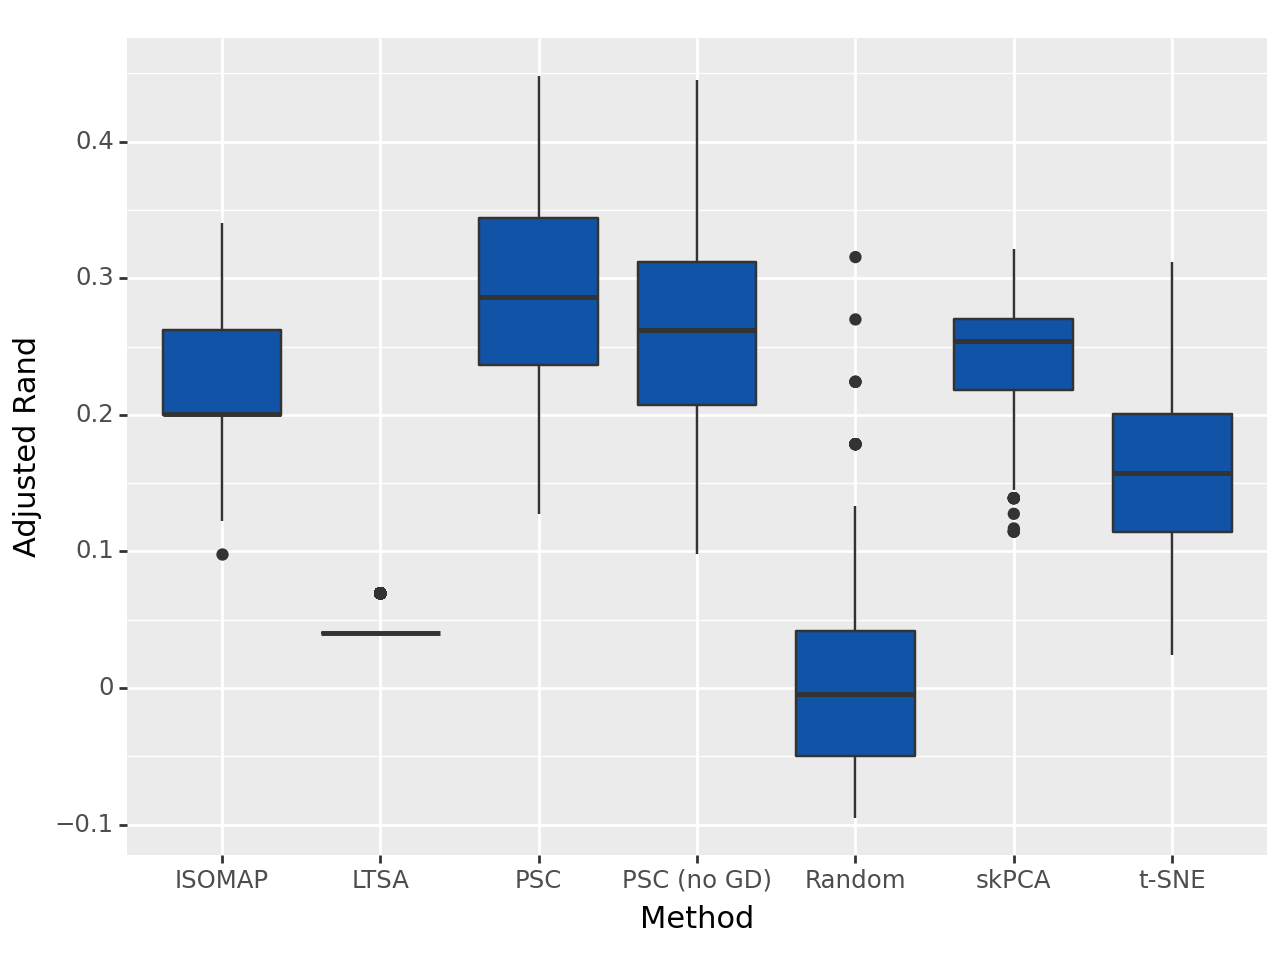

<Figure Size: (640 x 480)>

In [ ]:
ggplot(scores_report, aes(x="Method", y='Adjusted Rand')) + geom_boxplot(fill="#1153a6") #'Adjusted Rand','Adjusted Mutual Info','Homogeneity','Completeness','Fowlkes-Mallows'

## Additional Plots

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(X_isomap[:,0], X_isomap[:,1], X_isomap[:,2], c=subjects, s=100)
# ax.set_xlabel('Dim 1', fontsize=18, labelpad=10)
# ax.set_ylabel('Dim 2', fontsize=18, labelpad=10)
# ax.set_zlabel('Dim 3', fontsize=18, labelpad=10)
ax.set_title('ISOMAP', fontsize=20)

ax = fig.add_subplot(132, projection='3d')
ax.scatter(X_ltsa[:,0], X_ltsa[:,1], X_ltsa[:,2], c=subjects, s=100)
# ax.set_xlabel('Dim 1', fontsize=18, labelpad=10)
# ax.set_ylabel('Dim 2', fontsize=18, labelpad=10)
# ax.set_zlabel('Dim 3', fontsize=18, labelpad=10)
ax.set_title('LTSA', fontsize=20)

ax = fig.add_subplot(133, projection='3d')
ax.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], c=subjects, s=100)
# ax.set_xlabel('Dim 1', fontsize=18, labelpad=10)
# ax.set_ylabel('Dim 2', fontsize=18, labelpad=10)
# ax.set_zlabel('Dim 3', fontsize=18, labelpad=10)
ax.set_title('TSNE', fontsize=20)

# plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'brain-comparison.pdf'), dpi=300)
plt.show()

In [ ]:
S_hat = np.concatenate(ys, axis=-1) #np.sum(np.array([y.dot(y.T) for y in ys]), axis=0)/m
u, s, _ = np.linalg.svd(S_hat, full_matrices=False)

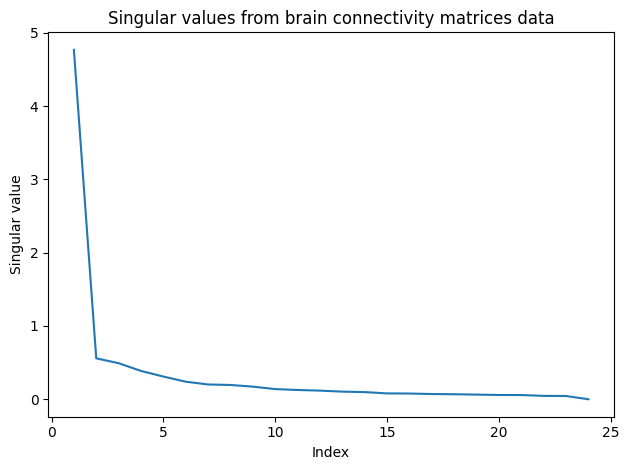

In [ ]:
plt.plot(np.array(range(len(s)))+1, s)

plt.title(r'Singular values from brain connectivity matrices data')
plt.xlabel('Index')
plt.ylabel('Singular value')
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'brain-singular-values.pdf'), dpi=300)